In [263]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from mpmath import *
import dynamiqs as dq
import jax.numpy as jnp
from scipy.ndimage import gaussian_filter1d
from jax import jit
import equinox as eqx


In [268]:
lam = 0.3
gamma_0 = 0.2
# Convert the function to JAX-compatible
@eqx.filter_jit
def Expr(t):
    # l = jnp.sqrt(lam**2 - 2 * gamma_0 * lam)
    l = np.emath.sqrt(lam**2 - 2*gamma_0*lam)

    expression = ((-l**2 + lam**2) * jnp.sinh(l * t / 2)) / (
        l * jnp.cosh(l * t / 2) + lam * jnp.sinh(l * t / 2)
    )
    return expression

def s(t):
    return np.imag(Expr(t))


def gam(t):
    return np.real(Expr(t))


time = np.linspace(0.1, 100, 100)  # Adjust time range as needed
tsave = jnp.round(time, 0)

# Calculate gam values
gam_vals = np.array([gam(t) for t in time])


def smoothen_gamma(gamma_vals, sigma=2):
    """
    Smoothen the gamma(t) values using a Gaussian filter.

    Parameters:
    gamma_vals (np.array): The input array of gamma(t) values.
    sigma (float): The standard deviation for Gaussian kernel. Higher values result in more smoothing.
    
    Returns:
    np.array: The smoothened gamma(t) array.
    """
    # Apply Gaussian filter for smoothing
    smoothened_gamma = gaussian_filter1d(gamma_vals, 3)
    return smoothened_gamma

gam_vals_new = smoothen_gamma(gam_vals)

tsave

Array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.], dtype=float32)

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
C:\Users\DELL\AppData\Local\Temp\ipykernel_14932\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14932\2974414707.py:6: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)


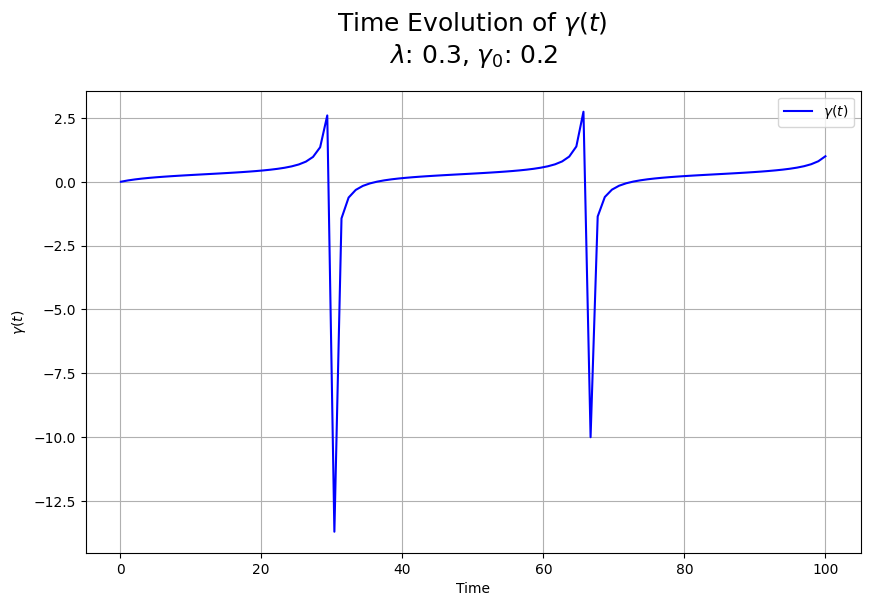

In [269]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time, gam_vals, label=r'$\gamma(t)$', color='b')
plt.xlabel('Time')
plt.ylabel(r'$\gamma(t)$')
plt.title(f"Time Evolution of $\gamma(t)$ \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)
plt.legend()
plt.grid(True)
plt.show()



In [270]:
tsave = jnp.linspace(0.1, 100, 100) 
tsave = jnp.round(tsave, 0)
# tsave = jnp.array([28.0, 29.0, 30.0, 31.0])  # Debug near specific discontinuities

psi = (dq.basis(2,0) + dq.basis(2,1))#*1/np.sqrt(2)

psi = dq.unit(psi)

rho = dq.todm(psi)

H = dq.zero(2)
# define list of observables
ops_and_rates = [[sigmap(),gam_vals_new]]  # time-dependent collapse term

# jump_ops = [dq.sigmap()]  
exp_ops = [dq.sigmaz(),dq.sigmax(), dq.sigmay()]  # expectation value of sigma_z, sigma_x


discontinuity_times = jnp.array([27.0, 28.0, 29.0, 30.0, 31.0, 76.0, 77.0, 78.0])  # Discontinuities at specific times
JO = dq.modulated(gam, dq.sigmap(), discontinuity_ts=discontinuity_times) # list of jump operators

res = dq.mesolve(
    H=H,  # Hamiltonian
    jump_ops=[JO],  # Collapse operators
    rho0=psi,  # Initial state
    tsave=tsave,  # Time points to save
    exp_ops=exp_ops,  # Expectation operators (optional)
    # options=options,  # Solver options
    solver=dq.solver.Tsit5(max_steps=1_000_000)
)

RuntimeError: An internal JAX error interrupted the execution, please report this to the Dynamiqs developers by opening an issue on GitHub or sending a message on Dynamiqs Slack (links available at https://www.dynamiqs.org/stable/community/lets-talk.html).

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\g'
C:\Users\DELL\AppData\Local\Temp\ipykernel_14932\1428702249.py:11: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
C:\Users\DELL\AppData\Local\Temp\ipykernel_14932\1428702249.py:11: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  retur

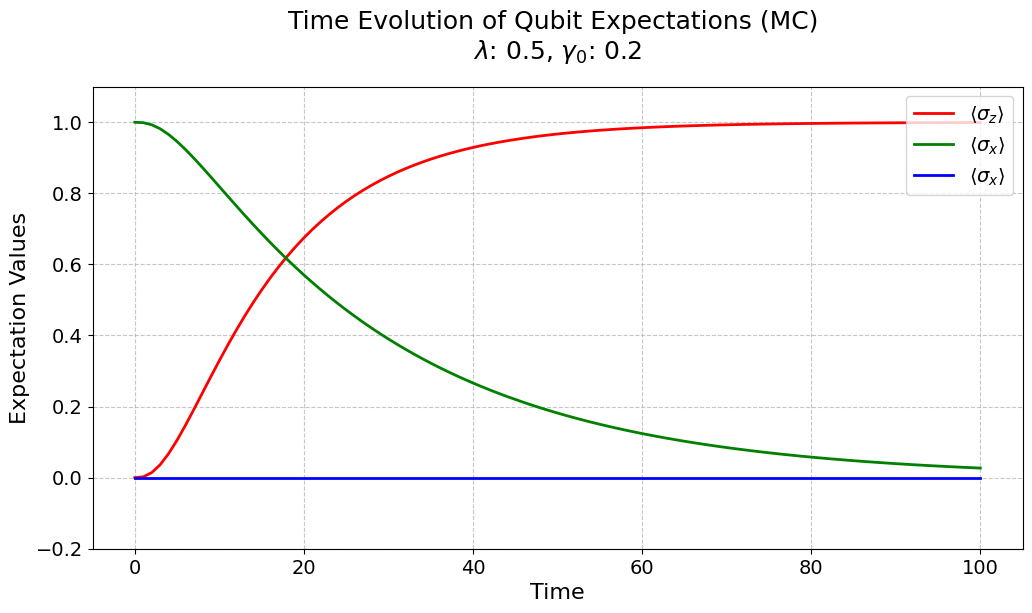

In [ ]:

data = res#mcsolve([[H0,s]], psi0, times, c_ops, e_ops, options = Options(store_states =True))
# Assuming result1.times and result1.expect are available
fig, ax = plt.subplots(figsize=(12, 6))
# Plotting the expectations with improved labels and colors
ax.plot(data.tsave, data.expects[0], 'r-', label=r'$\langle\sigma_z\rangle$', linewidth=2)
ax.plot(data.tsave, data.expects[1], 'g-', label=r'$\langle\sigma_x\rangle$', linewidth=2)
ax.plot(data.tsave, data.expects[2], 'b-', label=r'$\langle\sigma_x\rangle$', linewidth=2)


# Adding titles and labels with better formatting
ax.set_title(f"Time Evolution of Qubit Expectations (MC) \n$\lambda$: {lam}, $\gamma_0$: {gamma_0}", fontsize=18, pad=20)#("Time Evolution of Qubit Expectations(ME)" + "lam:":lam , , fontsize=18, pad=20)
ax.set_ylabel("Expectation Values", fontsize=16)
ax.set_xlabel("Time", fontsize=16)

# Adding a legend with improved positioning and font size
ax.legend(fontsize=14, loc='upper right')

# Adjusting y-axis limits for better visibility
ax.set_ylim(-0.2, 1.1)

# Adding a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adjusting tick parameters for better readability
ax.tick_params(axis='both', which='major', labelsize=14)

# Display the plot
plt.show()


In [ ]:
tsave = jnp.linspace(0.1, 100, 100) 
tsave = jnp.round(tsave, 0)
tsave

Array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.], dtype=float32)